In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import subprocess
import numpy as np
import time
import os
import sys

In [10]:
## Variable Define

# Base configuration
BASE_DIR = os.getcwd()
BENCHMARK_DIR = os.path.join(BASE_DIR, "benchmark")
LANGUAGES = ['go', 'python', 'c', 'rust']

# Function mappings for each category
FUNCTIONS = ['factorial', 'factors', 'sine', 'cosine', 'search', 'reverse', 'sum']

In [35]:
DataSet_Generation = True
executable_compilation = False
wasmedge_compilation = False
wasmedge_aot_compilation = True

# Generate file lists dynamically
def generate_file_lists():
    list_of_files = []
    list_of_dockers = []
    list_of_executable = []
    
    
    for lang in LANGUAGES:
        for func in FUNCTIONS:
            # Source files
            if lang == 'go':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, "main.go"))
            elif lang == 'python':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.py"))
            elif lang == 'c':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.cpp"))
            elif lang == 'rust':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, "src", "main.rs"))
            
            # Docker files
            if lang == 'python':
                list_of_dockers.append(os.path.join(BENCHMARK_DIR, lang, func, "Dockerfile.alpine"))
            else:
                list_of_dockers.append(os.path.join(BENCHMARK_DIR, lang, func, "Dockerfile"))
                list_of_dockers.append(os.path.join(BENCHMARK_DIR, lang, func, "Dockerfile.alpine"))
            
            # Executable files
            if lang == 'rust':
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, "target", "x86_64-unknown-linux-gnu", "release", func))
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, "target", "wasm32-wasip1", "release", f"{func}.wasm"))
            elif lang == 'python':
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.py"))
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm"))
            else:
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, func))
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm"))
    
    return list_of_files, list_of_dockers, list_of_executable

# Generate the lists
list_of_files, list_of_dockers, list_of_executable = generate_file_lists()

print(f"Generated {len(list_of_files)} source files")
print(f"Generated {len(list_of_dockers)} docker files") 
print(f"Generated {len(list_of_executable)} executable files")

Generated 28 source files
Generated 49 docker files
Generated 56 executable files


In [5]:

# Display sample of generated lists
print("Sample source files:")
for i, file in enumerate(list_of_files[:5]):
    print(f"  {i+1}. {file}")
print(f"... and {len(list_of_files)-5} more")

print("\nSample docker files:")
for i, file in enumerate(list_of_dockers[:5]):
    print(f"  {i+1}. {file}")
print(f"... and {len(list_of_dockers)-5} more")

print("\nSample executable files:")
for i, file in enumerate(list_of_executable[:5]):
    print(f"  {i+1}. {file}")
print(f"... and {len(list_of_executable)-5} more")

Sample source files:
  1. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/main.go
  2. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factors/main.go
  3. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/sine/main.go
  4. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/cosine/main.go
  5. /home/yash/Wasm-Benchmark/test/benchmark/Math/python/factorial/factorial.py
... and 23 more

Sample docker files:
  1. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/Dockerfile
  2. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/Dockerfile.alpine
  3. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factors/Dockerfile
  4. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factors/Dockerfile.alpine
  5. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/sine/Dockerfile
... and 44 more

Sample executable files:
  1. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/factorial
  2. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/factorial.wasm
  3. /h

In [13]:
## compilation
def get_path_info(file_path):
    """Extract category, language, and function from file path"""
    parts = file_path.split(os.sep)
    # Find benchmark directory index
    benchmark_idx = parts.index('benchmark')
    # category = parts[benchmark_idx + 1]
    lang = parts[benchmark_idx + 1]
    func = parts[benchmark_idx + 2]
    return lang, func

for file in list_of_files:
    if not os.path.exists(file):
        print(f"File not found: {file}")
        continue

    lang, func = get_path_info(file)
    print(f"Compiling {lang}/{func}")
    # category, lang, func = get_path_info(file)  --- IGNORE ---
    ## executable compilation
    if executable_compilation:
        if lang == 'go':
            output_path = os.path.join(BENCHMARK_DIR, lang, func, func)
            result = subprocess.run(['go', 'build', '-o', output_path, file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'c':
            output_path = os.path.join(BENCHMARK_DIR, lang, func, func)
            result = subprocess.run(['g++', '-o', output_path, file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'rust':
            cargo_path = os.path.join(BENCHMARK_DIR, lang, func, 'Cargo.toml')
            result = subprocess.run(['cargo', 'build', '--manifest-path', cargo_path, '--release', '--target=x86_64-unknown-linux-gnu'], capture_output=True, text=True)
            print(result.stdout)    
            print(result.stderr)
            
    ## wasmedge compilation
    if wasmedge_compilation:
        if lang == 'go':
            output_path = os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm")
            result = subprocess.run(['tinygo', 'build', '-o', output_path, '-target', 'wasi', file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'c':
            output_path = os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm")
            result = subprocess.run(['/home/yash/wasi-sdk/bin/clang++', '--target=wasm32-wasi', '-o', output_path, file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'rust':
            cargo_path = os.path.join(BENCHMARK_DIR, lang, func, 'Cargo.toml')
            result = subprocess.run(['cargo', 'build', '--manifest-path', cargo_path, '--release', '--target=wasm32-wasip1'], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'python':
            output_path = os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm")
            result = subprocess.run(["py2wasm", file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)

Compiling go/factorial
Compiling go/factors
Compiling go/sine
Compiling go/cosine
Compiling go/search
Compiling go/reverse
Compiling go/sum
Compiling python/factorial
Compiling python/factors
Compiling python/sine
Compiling python/cosine
Compiling python/search
Compiling python/reverse
Compiling python/sum
Compiling c/factorial
Compiling c/factors
Compiling c/sine
Compiling c/cosine
Compiling c/search
Compiling c/reverse
Compiling c/sum
Compiling rust/factorial
Compiling rust/factors
Compiling rust/sine
Compiling rust/cosine
Compiling rust/search
Compiling rust/reverse
Compiling rust/sum


In [21]:
list_of_compiled_wasm = []
# print(list_of_executable)

if wasmedge_aot_compilation:
    for file in list_of_executable:
        file_name = file.split(os.sep)[-1]
        file_format = file_name.split('.')[-1]
        func = file_name.split('.')[0]
        if file_format == 'wasm' and os.path.exists(file):
            compile_path = func + "_aot" + "." + file_format
            compile_path = file.replace(f"{func}.wasm", compile_path)
            print(file)
            # print(f"Compiling {file} to {compile_path}")
            list_of_compiled_wasm.append(compile_path)
            # result =compile_path = func + "_aot" + "." + file_format
            result = subprocess.run(["wasmedge", "compile", file, compile_path])
            print(result.stdout)
    print(list_of_compiled_wasm)




/home/yash/Wasm-Benchmark/test/benchmark/go/factorial/factorial.wasm
[2025-09-18 18:55:02.422] [info] compile start
[2025-09-18 18:55:02.460] [info] verify start
[2025-09-18 18:55:02.502] [info] optimize start
[2025-09-18 18:55:04.057] [info] optimize done
[2025-09-18 18:55:04.057] [info] codegen start
[2025-09-18 18:55:05.347] [info] output start
[2025-09-18 18:55:05.357] [info] codegen done
[2025-09-18 18:55:05.358] [info] output start
[2025-09-18 18:55:05.359] [info] output done
None
/home/yash/Wasm-Benchmark/test/benchmark/go/factors/factors.wasm
[2025-09-18 18:55:05.384] [info] compile start
[2025-09-18 18:55:05.416] [info] verify start
[2025-09-18 18:55:05.448] [info] optimize start
[2025-09-18 18:55:06.911] [info] optimize done
[2025-09-18 18:55:06.911] [info] codegen start
[2025-09-18 18:55:08.091] [info] output start
[2025-09-18 18:55:08.094] [info] codegen done
[2025-09-18 18:55:08.095] [info] output start
[2025-09-18 18:55:08.095] [info] output done
None
/home/yash/Wasm-Benc

In [ ]:
## docker file building

print(list_of_dockers)

for file in list_of_dockers:
    if not os.path.exists(file):
        print(f"Dockerfile not found: {file}")
        continue
        
    print(f"Building Docker image for {file}")
    lang, func = get_path_info(file)
    dockerfile_name = os.path.basename(file)
    build_context = os.path.join(BENCHMARK_DIR, lang, func)
    print("build_context", build_context)

    print(f"Dockerfile: {dockerfile_name}, Language: {lang}, Function: {func}")

    if dockerfile_name == "Dockerfile.alpine":
        image_tag = f"yaskam24/{lang}_alpine:{func}"
        result = subprocess.run(["docker", "build", "-t", image_tag, "-f", file, build_context], capture_output=True, text=True)
        print(result.stdout)
    else:
        image_tag = f"yaskam24/{lang}:{func}"
        result = subprocess.run(["docker", "build", "-t", image_tag, "-f", file, build_context], capture_output=True, text=True)
        print(result.stdout)


['/home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/Dockerfile', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/factors/Dockerfile', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/factors/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/sine/Dockerfile', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/sine/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/cosine/Dockerfile', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/cosine/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/python/factorial/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/python/factors/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/python/sine/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/python/cosine/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/c/factorial/Dockerfile', '/home/ya

## DataSet Generation

In [ ]:
list_of_results = []
n = len(list_of_dockers)
for file in list_of_dockers:
    if not os.path.exists(file):
        print(f"Dockerfile not found: {file}")
        continue
    print(file)
    lang, func = get_path_info(file)
    dockerfile_name = os.path.basename(file)
    print(f"Function: {func}, Language: {lang}")
    
    if dockerfile_name == "Dockerfile.alpine":
        tag = "alpine"
        image_name = f"yaskam24/{lang}_alpine:{func}"
        avg_container_creation = 0
        avg_execution_time = 0
        for i in range(1, 11):
            start_time = time.time_ns()
            result = subprocess.run(["docker", "run", "--rm", image_name], capture_output=True, text=True)
            output = result.stdout.split('\n')
            print(output)
            exec_time = None
            for line in output:
                if line.startswith("Execution time:"):
                    exec_time = float(line.split()[2])  # seconds as float
                    break
            Start_time = None
            for line in output:
                if line.startswith("Start time:"):
                    Start_time = line.split()[2]  # seconds as float
                    break
            container_creation_duration = (int(Start_time) - start_time)/1e9
            avg_container_creation += container_creation_duration
            avg_execution_time += exec_time
        avg_container_creation /= 10
        avg_execution_time /= 10
    else:
        tag = "wasmedge/slim-runtime"
        image_name = f"yaskam24/{lang}:{func}"
        avg_container_creation = 0
        avg_execution_time = 0
        for i in range(1, 11):
            start_time = time.time_ns()
            result = subprocess.run(["docker", "run", "--rm", image_name], capture_output=True, text=True)
            output = result.stdout.split('\n')
            print(output)
            exec_time = None
            for line in output:
                if line.startswith("Execution time:"):
                    exec_time = float(line.split()[2])  # seconds as float
                    break
            Start_time = None
            for line in output:
                if line.startswith("Start time:"):
                    Start_time = line.split()[2]  # seconds as float
                    break
            container_creation_duration = (int(Start_time) - start_time)/1e9
            avg_container_creation += container_creation_duration
            avg_execution_time += exec_time
        avg_execution_time /= 10
        avg_container_creation /= 10
    list_of_results.append({
        "language": lang,
        "function": func,
        "avg_execution_time": avg_execution_time,
        "start_time": start_time,
        "container_creation": avg_container_creation,
        "Env": tag
    })

container_data = pd.DataFrame(list_of_results)
container_data["Execution_Time"] = container_data["avg_execution_time"] + container_data["container_creation"]
print(container_data.head(n))

container_data.to_csv("benchmarking_results/container_benchmark_results.csv", index=False)

/home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/Dockerfile
Category: Math, Function: factorial, Language: go
['Start time: 1757916202887271083 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000938 seconds', '']
['Start time: 1757916203361091843 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.001012 seconds', '']
['Start time: 1757916203804544813 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000585 seconds', '']
['Start time: 1757916204199308111 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000673 seconds', '']
['Start time: 1757916204608650392 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000606 seconds', '']
['Start time: 1757916205013218397 ns', 'Sum of fac

In [37]:
## executable_data



list_of_results_executable = []
n = len(list_of_executable)
print(n)

def get_executable_path_info(file_path):
    """Extract category, language, and function from executable file path"""
    parts = file_path.split(os.sep)
    benchmark_idx = parts.index('benchmark')
    lang = parts[benchmark_idx + 1]
    func = parts[benchmark_idx + 2]
    funcwithform = parts[-1]
    return lang, func, funcwithform

# if list_of_compiled_wasm is not None:
#     list_of_executable.extend(list_of_compiled_wasm)
#     print(list_of_executable)

for file in list_of_executable:
    
    if not os.path.exists(file):
        print(f"Executable not found: {file}")
        continue

    lang, func, funcwithform = get_executable_path_info(file)
    print(f"Running {lang}/{func}")

    # Determine if it's wasm or executable
    if file.endswith(".wasm"):
        tag = "wasm"
    else:
        tag = "executable"

    print(f"Function: {func}, Language: {lang}, tag: {tag}")

    # Determine input parameter based on function
    if func in ["factorial", "factors", "sine", "cosine"]:
        input_param = "40"
    elif func in ["search", "reverse", "sum"]:
        input_param = "10000"  # Array size
    else:
        input_param = "1000"  # Default
    
    avg_execution_time = 0
    for i in range(1, 11):
        if lang == "c" and tag == "executable":
            result = subprocess.run([file, input_param], capture_output=True, text=True)
        elif lang == "go" and tag == "executable":
            result = subprocess.run([file, input_param], capture_output=True, text=True)
        elif lang == "python" and tag == "executable":
            result = subprocess.run(["python", file, input_param], capture_output=True, text=True)
        elif lang == "rust" and tag == "executable":
            result = subprocess.run([file, input_param], capture_output=True, text=True)
        elif lang != "rust" and tag == "wasm":
            result = subprocess.run(["wasmedge", file, input_param], capture_output=True, text=True)
        elif lang == "rust" and tag == "wasm":
            result = subprocess.run(["wasmedge", file, input_param], capture_output=True, text=True)
        else:
            continue
            
        result = result.stdout
        output = result.split('\n')
        print(output)
        exec_time = None
        for line in output:
            if line.startswith("Execution time:"):
                exec_time = float(line.split()[2])  # seconds as float
                break
        avg_execution_time += exec_time

    print(tag)
    list_of_results_executable.append({
        "language": lang,
        "function": func,
        "execution_time": avg_execution_time/10,
        "Env": tag if tag == "executable" else "wasmedge"
    })
    
    avg_execution_time = 0
    if tag == "wasm":
        for i in range(1, 11):
            result = subprocess.run(["wasmtime", file, input_param], capture_output=True, text=True)
            result = result.stdout
            output = result.split('\n')
            print(output)
            exec_time = None
            for line in output:
                if line.startswith("Execution time:"):
                    exec_time = float(line.split()[2])  # seconds as float
                    break
            avg_execution_time += exec_time

        list_of_results_executable.append({
            "language": lang,
            "function": func,
            "execution_time": avg_execution_time/10,
            "Env": "wasmtime"
        })

for file in list_of_compiled_wasm:
    if not os.path.exists(file):
        print(f"Executable not found: {file}")
        continue

    lang, func, funcwithform = get_executable_path_info(file)
    print(f"Running {lang}/{func}", funcwithform)   
    if func in ["factors", "factorial", "sine", "cosine"]:
         input_param = "40"
    elif func in ["sum", "reverese", "sort", "search"]:
         input_param = "10000"
    else:
         input_param = "1000"
    
    if file.endswith("aot.wasm"):
        tag = "aot"

    avg_execution_time = 0
    for i in range(1, 11):
            result = subprocess.run(["wasmedge", file, input_param], capture_output=True, text=True)
            result = result.stdout
            output = result.split('\n')
            print(output)
            exec_time = None
            for line in output:
                if line.startswith("Execution time:"):
                    exec_time = float(line.split()[2])  # seconds as float
                    break
            avg_execution_time += exec_time

    list_of_results_executable.append({
        "language": lang,
        "function": func,
        "execution_time": avg_execution_time/10,
        "Env": tag
    })

execution_data = pd.DataFrame(list_of_results_executable)
print(execution_data.head(n))
execution_data.to_csv("benchmarking_results/executable_benchmark_results.csv", index=False)



56
Running go/factorial
Function: factorial, Language: go, tag: executable
['Start time: 1758205349299169220 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000023 seconds', '']
['Start time: 1758205349300703854 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000022 seconds', '']
['Start time: 1758205349303296978 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000024 seconds', '']
['Start time: 1758205349304744466 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000020 seconds', '']
['Start time: 1758205349306095967 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000018 seconds', '']
['Start time: 1758205349307170244 ns', 'Sum of factorials from 1 to 40 is: 83685033433031539666

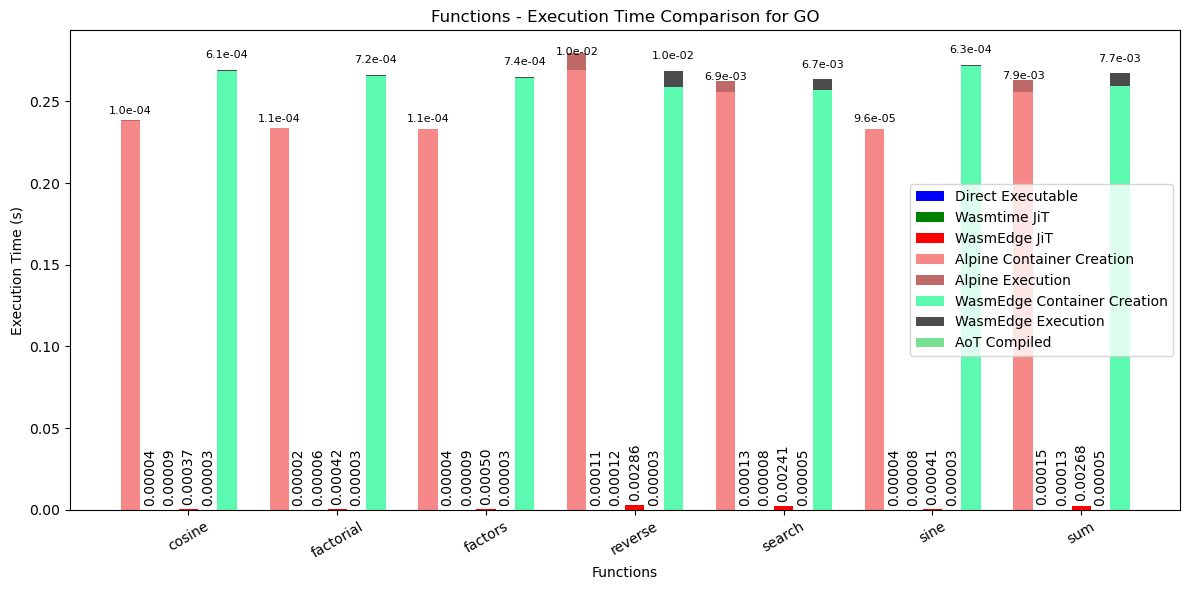

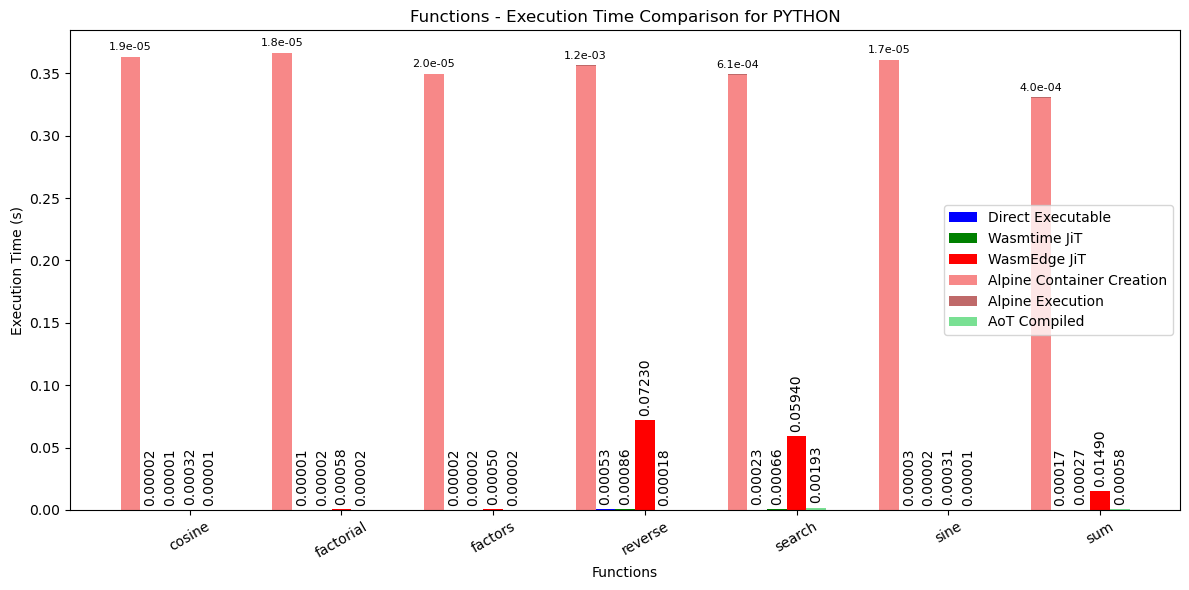

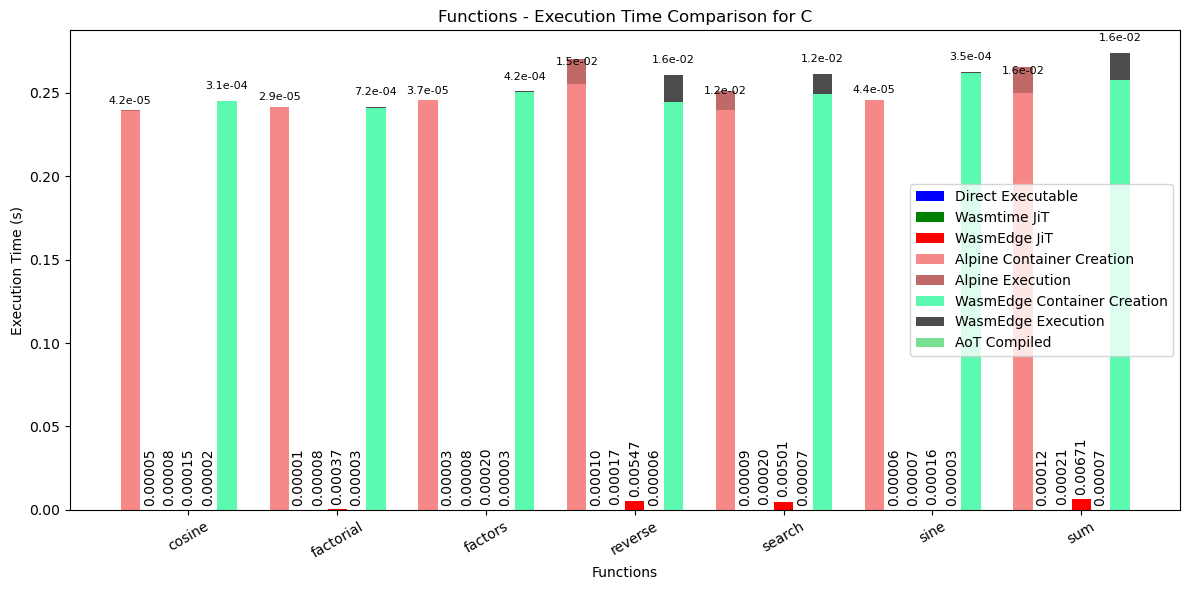

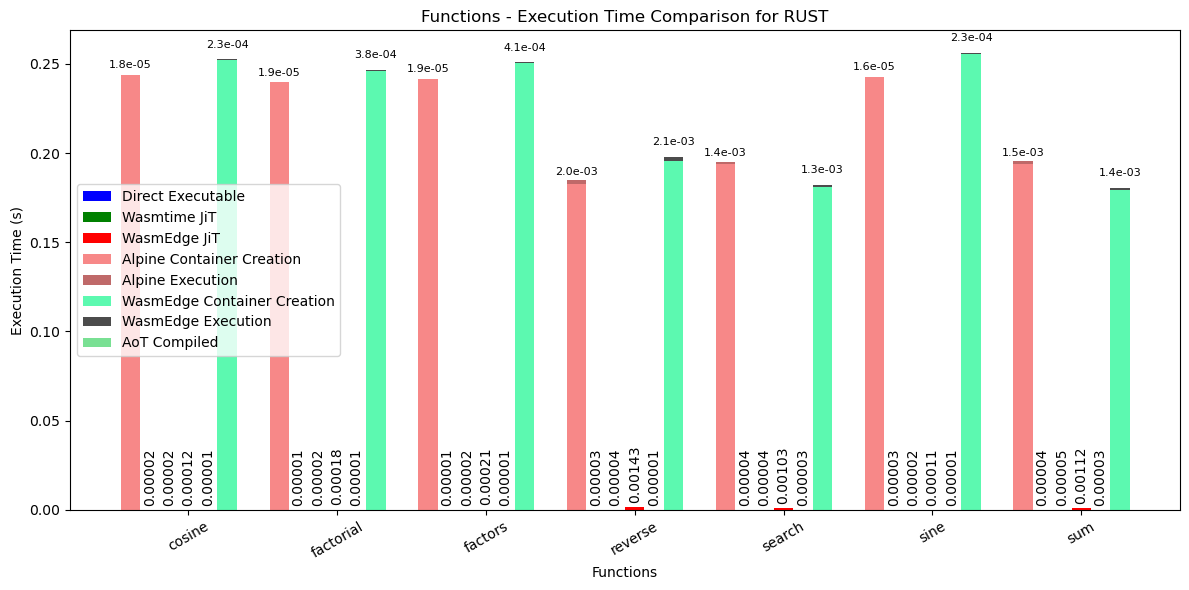

In [53]:
# direct_executable = execution_data[execution_data['Env'] == 'executable']
# # print(direct_executable)
# print(direct_executable[direct_executable['language'] == 'go'])
# wasmedge_executable = execution_data[execution_data['Env'] == 'wasmedge']
# # print(wasmedge_executable)
# particular_lang = wasmedge_executable[wasmedge_executable['language'] == 'go']
# print(wasmedge_executable[wasmedge_executable['language'] == 'go'])
# print(particular_lang['execution_time'])
# container_data = pd.read_csv("benchmarking_results/container_benchmark_results.csv")

# print(container_data)

execution_data = pd.read_csv("benchmarking_results/executable_benchmark_results.csv")
container_data = pd.read_csv("benchmarking_results/container_benchmark_results.csv")



# Create visualizations for each category and language combination

for lang in LANGUAGES:
    exec_data = execution_data[execution_data["language"] == lang]
    cont_data = container_data[container_data["language"] == lang]
    
    if exec_data.empty and cont_data.empty:
        continue

        # remove all the row which has sort function
        # exec_data = exec_data[exec_data["function"] != "sort"]
    cont_data = cont_data[cont_data["function"] != "sort"]

    aot_exec = exec_data[exec_data["Env"] == "aot"].sort_values(by="function")
    wasmtime_exec = exec_data[exec_data["Env"] == "wasmtime"].sort_values(by="function")
    # Split by environment
    direct_exec = exec_data[exec_data["Env"] == "executable"].sort_values(by="function")
    # print(direct_exec)
    wasmedge_exec = exec_data[exec_data["Env"] == "wasmedge"].sort_values(by="function")
    # print(wasmedge_exec)
    alpine_cont = cont_data[cont_data["Env"] == "alpine"].sort_values(by="function")
    # print(alpine_cont)
    wasmedge_cont = cont_data[cont_data["Env"] == "wasmedge/slim-runtime"].sort_values(by="function")
    # print(wasmedge_cont)
    # Get unique functions for this category/lang combination
    all_functions = set()
    for df in [direct_exec, wasmedge_exec, alpine_cont, wasmedge_cont, aot_exec]:
        if not df.empty:
            all_functions.update(df["function"].tolist())

    if "sort" in all_functions:
        all_functions.remove("sort")
    # print(all_functions)
    functions = sorted(list(all_functions))
    if not functions:
        continue
        
    x = np.arange(len(functions))


    plt.figure(figsize=(12, 6))

    bar_width = 0.13  

    offsets = {
        "alpine_cont":    -3 * bar_width,
        "direct_exec":   -2 * bar_width,
        "wasmtime_exec": -1 * bar_width,
        "wasmedge_exec":  0 * bar_width,
        "aot_exec":       1 * bar_width,
        
        "wasmedge_cont":  2 * bar_width,

    }

    if not direct_exec.empty:
        bar1 = plt.bar(x + offsets["direct_exec"], direct_exec["execution_time"], bar_width,
                    label="Direct Executable", color="blue")

    if not wasmtime_exec.empty:
        bar7 = plt.bar(x + offsets["wasmtime_exec"], wasmtime_exec["execution_time"], bar_width,
                    label="Wasmtime JiT", color="green")

    if not wasmedge_exec.empty:
        bar2 = plt.bar(x + offsets["wasmedge_exec"], wasmedge_exec["execution_time"], bar_width,
                    label="WasmEdge JiT", color="red")

    if not alpine_cont.empty:
        bar3 = plt.bar(x + offsets["alpine_cont"], alpine_cont["container_creation"], bar_width,
                    label="Alpine Container Creation", color="#f56868c9")
        bar5 = plt.bar(x + offsets["alpine_cont"], alpine_cont["avg_execution_time"], bar_width,
                    bottom=alpine_cont["container_creation"], label="Alpine Execution",
                    color="brown", alpha=0.7)

    if not wasmedge_cont.empty:
        bar4 = plt.bar(x + offsets["wasmedge_cont"], wasmedge_cont["container_creation"], bar_width,
                    label="WasmEdge Container Creation", color="#31f89bca")
        bar6 = plt.bar(x + offsets["wasmedge_cont"], wasmedge_cont["avg_execution_time"], bar_width,
                    bottom=wasmedge_cont["container_creation"], label="WasmEdge Execution",
                    color="black", alpha=0.7)

    if not aot_exec.empty:
        bar8 = plt.bar(x + offsets["aot_exec"], aot_exec["execution_time"], bar_width,
                    label="AoT Compiled", color="#54d875c8")

    # Labels and style
    plt.xlabel("Functions")
    plt.ylabel("Execution Time (s)")
    plt.title(f"Functions - Execution Time Comparison for {lang.upper()}")
    plt.xticks(x, functions, rotation=30)
    plt.legend()

    # Add values on bars
    if not direct_exec.empty:
        plt.bar_label(bar1, padding=3, fmt="%.5f", rotation=90)
    if not wasmedge_exec.empty:
        plt.bar_label(bar2, padding=3, fmt="%.5f", rotation=90)
    if not alpine_cont.empty:
        plt.bar_label(bar5, labels=[f"{h:.1e}" for h in alpine_cont["avg_execution_time"]], rotation=0, label_type="center", padding=7, fontsize=8)
    if not wasmedge_cont.empty:
        plt.bar_label(bar6, labels=[f"{h:.1e}" for h in wasmedge_cont["avg_execution_time"]], rotation=0, label_type="edge", padding=7, fontsize=8)
    if not aot_exec.empty:
        plt.bar_label(bar8, padding=3, fmt="%.5f", rotation=90)
    if not wasmtime_exec.empty:
        plt.bar_label(bar7, padding=3, fmt="%.5f", rotation=90)

    plt.tight_layout()
    plt.show()


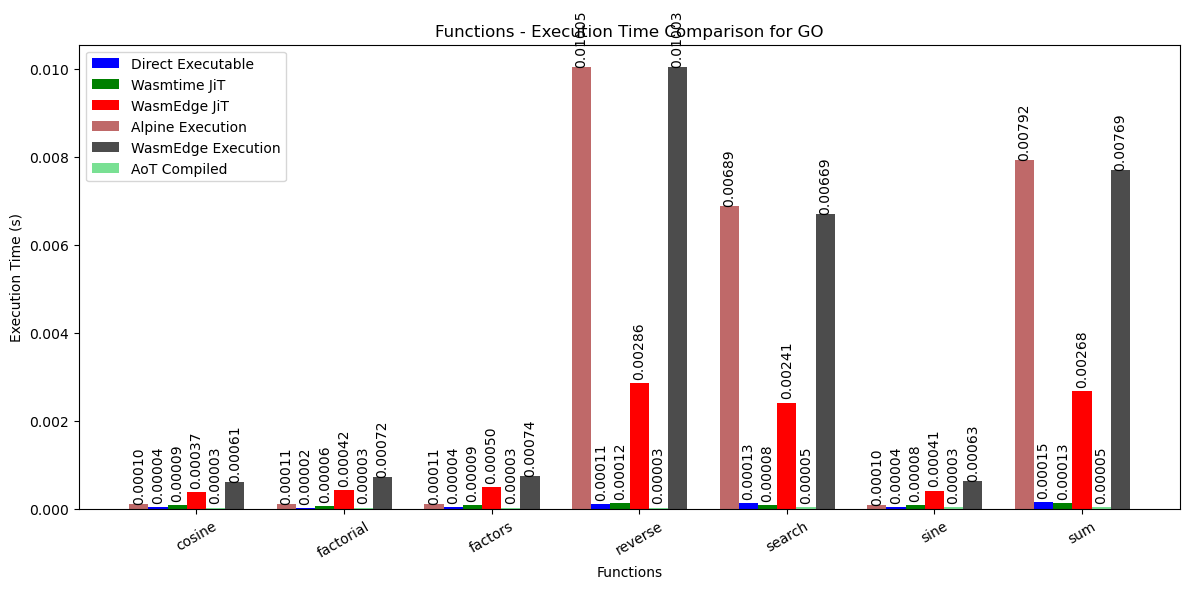

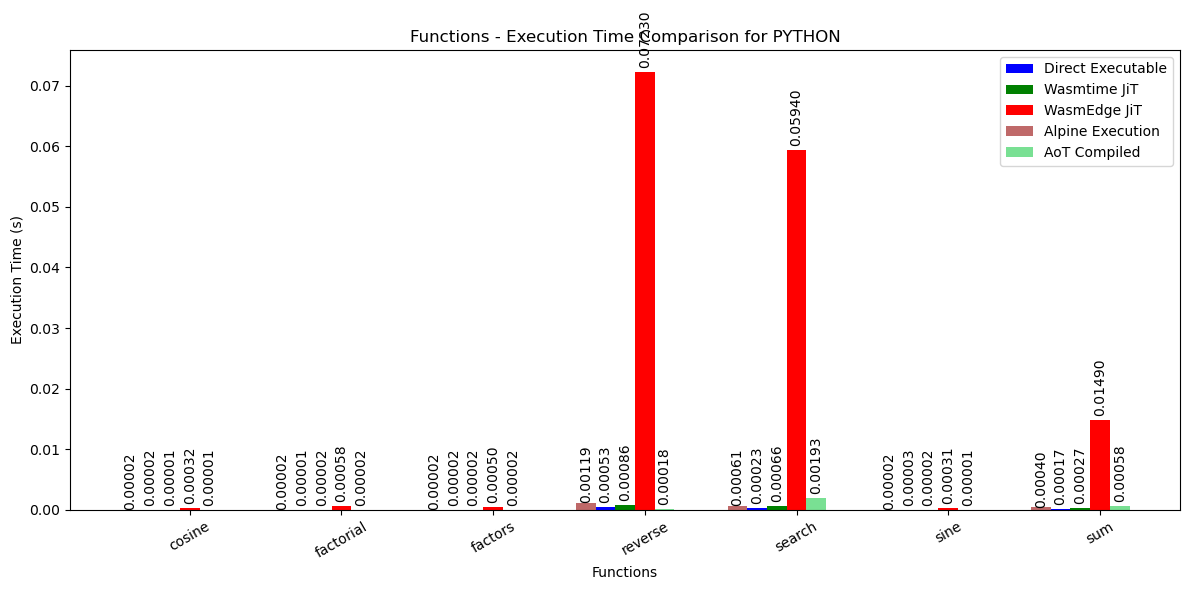

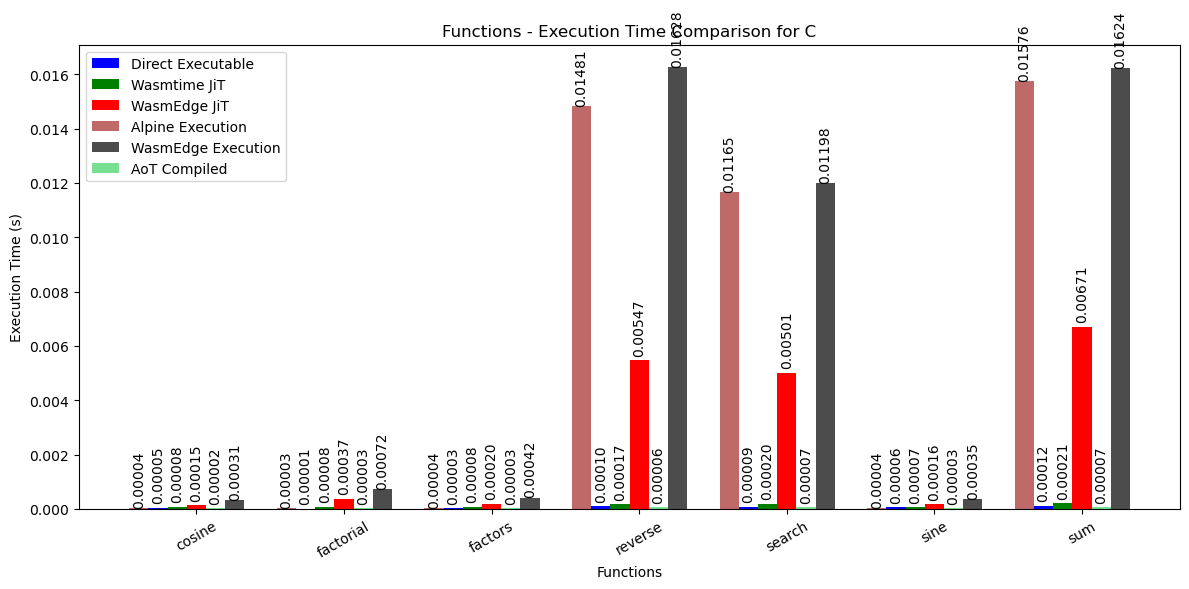

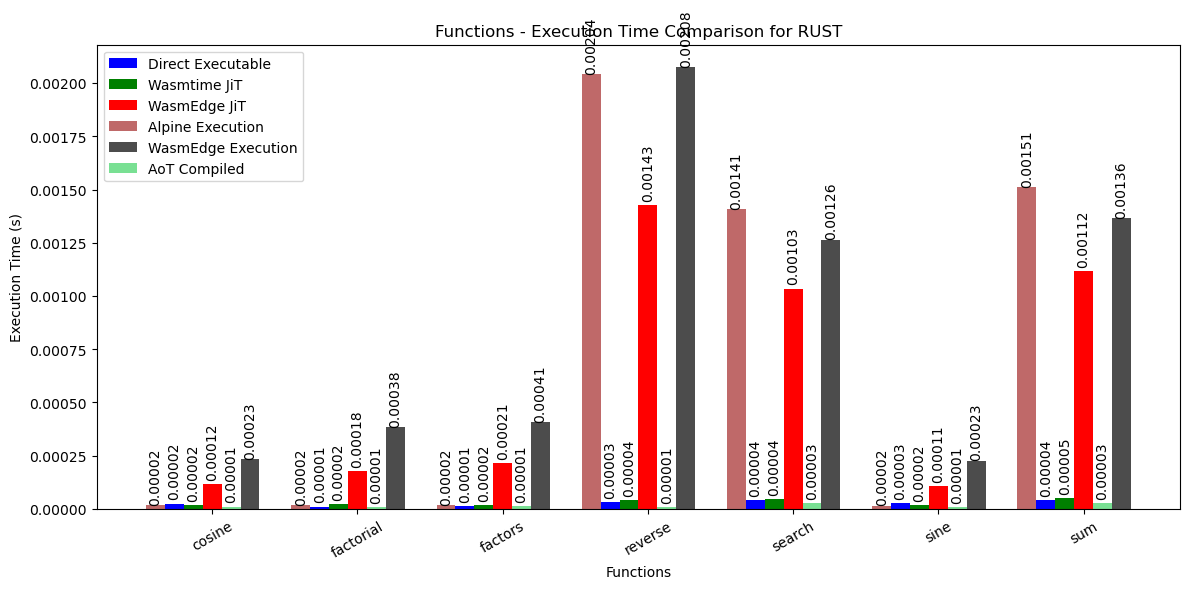

In [60]:

execution_data = pd.read_csv("benchmarking_results/executable_benchmark_results.csv")
container_data = pd.read_csv("benchmarking_results/container_benchmark_results.csv")



# Create visualizations for each category and language combination

for lang in LANGUAGES:
    exec_data = execution_data[execution_data["language"] == lang]
    cont_data = container_data[container_data["language"] == lang]
    
    if exec_data.empty and cont_data.empty:
        continue

        # remove all the row which has sort function
        # exec_data = exec_data[exec_data["function"] != "sort"]
    cont_data = cont_data[cont_data["function"] != "sort"]

    aot_exec = exec_data[exec_data["Env"] == "aot"].sort_values(by="function")
    wasmtime_exec = exec_data[exec_data["Env"] == "wasmtime"].sort_values(by="function")
    # Split by environment
    direct_exec = exec_data[exec_data["Env"] == "executable"].sort_values(by="function")
    # print(direct_exec)
    wasmedge_exec = exec_data[exec_data["Env"] == "wasmedge"].sort_values(by="function")
    # print(wasmedge_exec)
    alpine_cont = cont_data[cont_data["Env"] == "alpine"].sort_values(by="function")
    # print(alpine_cont)
    wasmedge_cont = cont_data[cont_data["Env"] == "wasmedge/slim-runtime"].sort_values(by="function")
    # print(wasmedge_cont)
    # Get unique functions for this category/lang combination
    all_functions = set()
    for df in [direct_exec, wasmedge_exec, alpine_cont, wasmedge_cont, aot_exec]:
        if not df.empty:
            all_functions.update(df["function"].tolist())

    if "sort" in all_functions:
        all_functions.remove("sort")
    # print(all_functions)
    functions = sorted(list(all_functions))
    if not functions:
        continue
        
    x = np.arange(len(functions))


    plt.figure(figsize=(12, 6))

    bar_width = 0.13  

    offsets = {
        "alpine_cont":    -3 * bar_width,
        "direct_exec":   -2 * bar_width,
        "wasmtime_exec": -1 * bar_width,
        "wasmedge_exec":  0 * bar_width,
        "aot_exec":       1 * bar_width,
        
        "wasmedge_cont":  2 * bar_width,

    }

    if not direct_exec.empty:
        bar1 = plt.bar(x + offsets["direct_exec"], direct_exec["execution_time"], bar_width,
                    label="Direct Executable", color="blue")

    if not wasmtime_exec.empty:
        bar7 = plt.bar(x + offsets["wasmtime_exec"], wasmtime_exec["execution_time"], bar_width,
                    label="Wasmtime JiT", color="green")

    if not wasmedge_exec.empty:
        bar2 = plt.bar(x + offsets["wasmedge_exec"], wasmedge_exec["execution_time"], bar_width,
                    label="WasmEdge JiT", color="red")

    if not alpine_cont.empty:
        # bar3 = plt.bar(x + offsets["alpine_cont"], alpine_cont["container_creation"], bar_width,
        #             label="Alpine Container Creation", color="#f56868c9")
        bar5 = plt.bar(x + offsets["alpine_cont"], alpine_cont["avg_execution_time"], bar_width, label="Alpine Execution",
                    color="brown", alpha=0.7)

    if not wasmedge_cont.empty:
        # bar4 = plt.bar(x + offsets["wasmedge_cont"], wasmedge_cont["container_creation"], bar_width,
                    # label="WasmEdge Container Creation", color="#31f89bca")
        bar6 = plt.bar(x + offsets["wasmedge_cont"], wasmedge_cont["avg_execution_time"], bar_width,
                    label="WasmEdge Execution",
                    color="black", alpha=0.7)

    if not aot_exec.empty:
        bar8 = plt.bar(x + offsets["aot_exec"], aot_exec["execution_time"], bar_width,
                    label="AoT Compiled", color="#54d875c8")

    # Labels and style
    plt.xlabel("Functions")
    plt.ylabel("Execution Time (s)")
    plt.title(f"Functions - Execution Time Comparison for {lang.upper()}")
    plt.xticks(x, functions, rotation=30)
    plt.legend()

    # Add values on bars
    if not direct_exec.empty:
        plt.bar_label(bar1, padding=3, fmt="%.5f", rotation=90)
    if not wasmedge_exec.empty:
        plt.bar_label(bar2, padding=3, fmt="%.5f", rotation=90)
    if not alpine_cont.empty:
        plt.bar_label(bar5, rotation=90, fmt="%.5f")
    if not wasmedge_cont.empty:
        plt.bar_label(bar6, rotation=90, fmt="%.5f")
    if not aot_exec.empty:
        plt.bar_label(bar8, padding=3, fmt="%.5f", rotation=90)
    if not wasmtime_exec.empty:
        plt.bar_label(bar7, padding=3, fmt="%.5f", rotation=90)

    plt.tight_layout()
    plt.show()


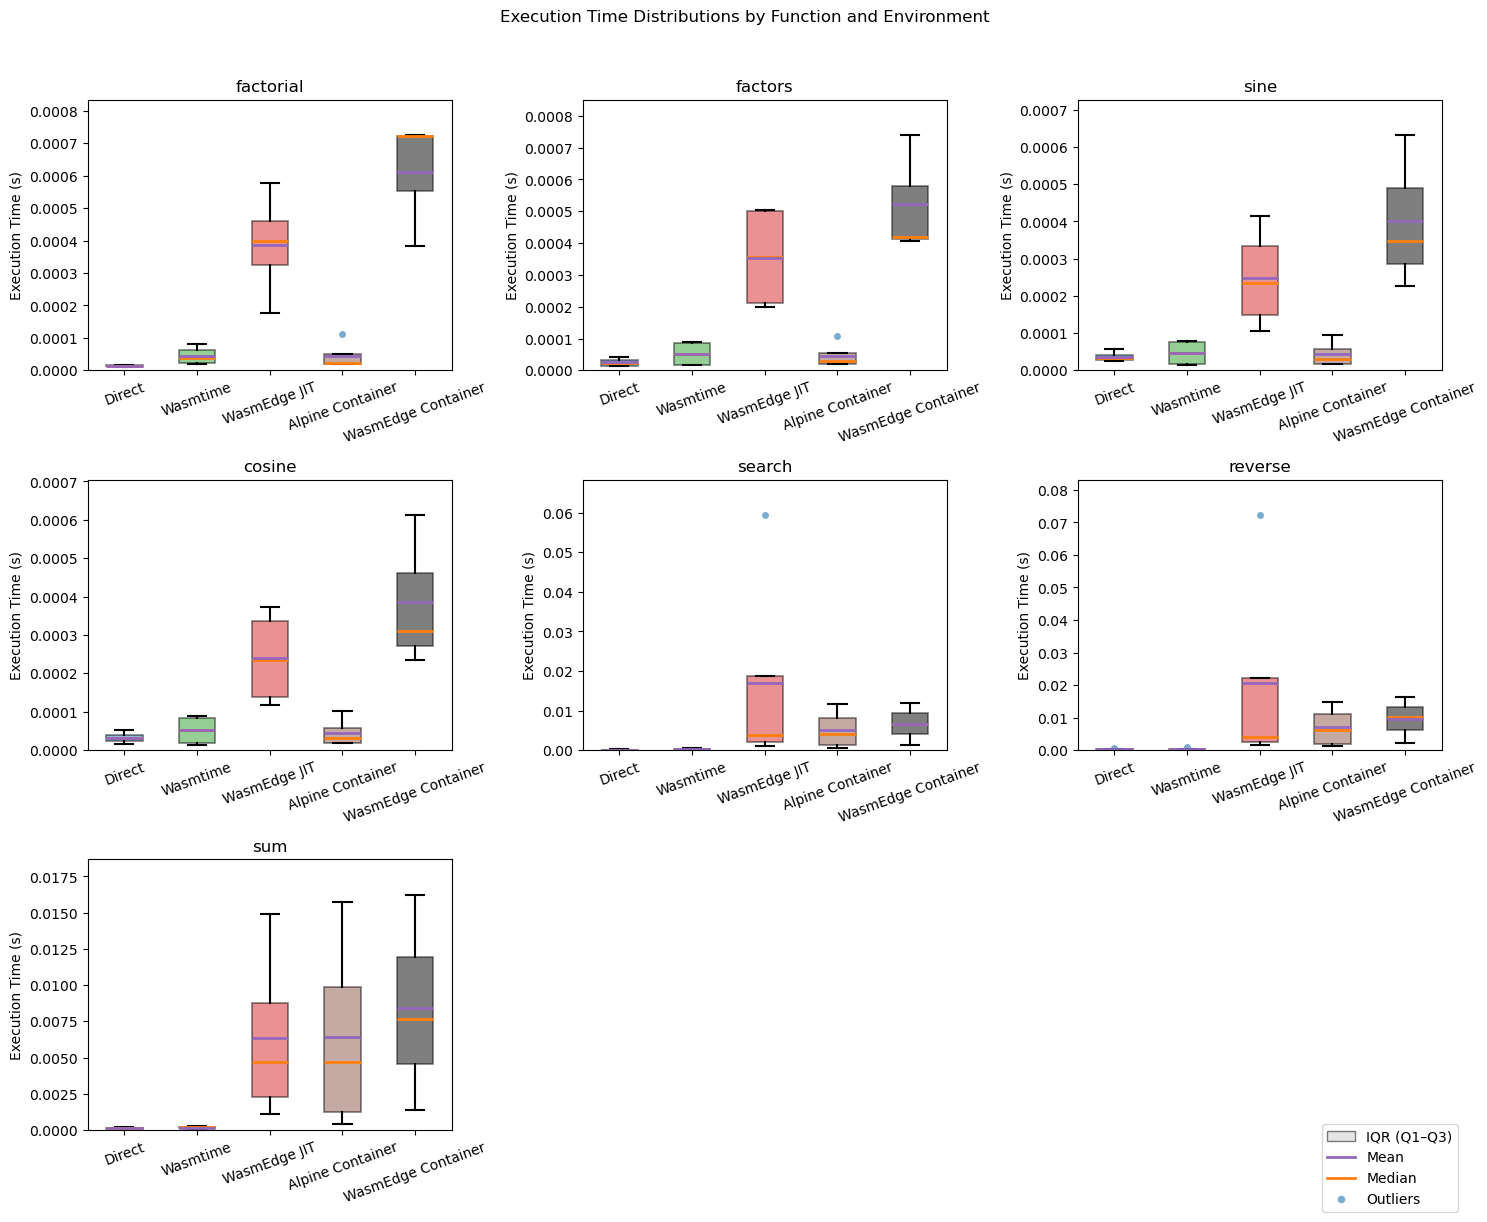

In [61]:


# Grid of box plots: per function, x-axis = environment, y-axis = execution time
# Uses execution-only times: direct/wasmtime/wasmedge executables and container avg_execution_time

# Prepare environment order and pretty labels (insert WasmEdge Compiled after Direct)
# Ensure compiled_df is loaded
ENV_SPECS = [
    ("executable", "Direct"),
    ("wasmedge_compiled", "WasmEdge AOT"),
    ("wasmtime", "Wasmtime"),
    ("wasmedge", "WasmEdge JIT"),
    ("alpine", "Alpine Container"),
    ("wasmedge/slim-runtime", "WasmEdge Container"),
]

# Prepare list of functions to plot (exclude sort)
funcs = [f for f in FUNCTIONS if f != "sort"]
num_funcs = len(funcs)
if num_funcs == 0:
    print("No functions to plot.")
else:
    # Choose a near-square grid
    cols = int(np.ceil(np.sqrt(num_funcs)))
    rows = int(np.ceil(num_funcs / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.2 * rows), squeeze=False, sharey=False)

    for idx, func in enumerate(funcs):
        r, c = divmod(idx, cols)
        ax = axes[r][c]

        data_lists = []
        labels = []
        for env_key, env_label in ENV_SPECS:
            if env_key in ("executable", "wasmtime", "wasmedge", "aot"):
                vals = execution_data[(execution_data["function"] == func) & (execution_data["Env"] == env_key)]["execution_time"].values
            else:
                vals = container_data[(container_data["function"] == func) & (container_data["Env"] == env_key)]["avg_execution_time"].values
            vals = vals[~np.isnan(vals)] if len(vals) else vals
            if len(vals):
                data_lists.append(vals)
                labels.append(env_label)

        if data_lists:
            # Standardize boxplot line styles for consistent legend meanings
            medianprops = dict(color="#ff7f0e", linewidth=2)
            meanprops = dict(color="#9467bd", linewidth=2, linestyle='-')
            whiskerprops = dict(color="black", linewidth=1.5)
            capprops = dict(color="black", linewidth=1.5)
            boxprops = dict(edgecolor="black", linewidth=1.2)
            flierprops = dict(marker='o', markerfacecolor="#1f77b4", markersize=5, alpha=0.6, markeredgecolor='none')

            bp = ax.boxplot(
                data_lists,
                tick_labels=labels,
                patch_artist=True,
                showmeans=True,
                meanline=True,
                meanprops=meanprops,
                medianprops=medianprops,
                whiskerprops=whiskerprops,
                capprops=capprops,
                boxprops=boxprops,
                flierprops=flierprops,
            )
            # Simple coloring for visibility of IQR boxes
            colors = ["#1f77b4", "#2ca02c", "#d62728", "#8c564b", "#000000"]
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.5)
            # Per-subplot ylim with headroom
            local_max = max([np.nanmax(v) for v in data_lists])
            if local_max > 0:
                ax.set_ylim(0, float(local_max) * 1.15)
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.set_xticks([])

        ax.set_title(f"{func}")
        # ax.set_xlabel("Environment")
        ax.set_ylabel("Execution Time (s)")
        ax.tick_params(axis='x', rotation=20)

    # Hide any unused subplots
    for j in range(num_funcs, rows * cols):
        r, c = divmod(j, cols)
        axes[r][c].axis('off')

    # Figure-level legend explaining boxplot elements in bottom-right
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    legend_handles = [
        Patch(facecolor="#cccccc", edgecolor="black", alpha=0.5, label="IQR (Q1–Q3)"),
        Line2D([0], [0], color="#9467bd", lw=2, label="Mean"),
        Line2D([0], [0], color="#ff7f0e", lw=2, label="Median"),
        Line2D([0], [0], marker='o', color='w', markerfacecolor="#1f77b4", markersize=6, alpha=0.6, label="Outliers"),
    ]
    fig.legend(handles=legend_handles, loc='lower right', bbox_to_anchor=(0.98, 0.02))

    fig.suptitle("Execution Time Distributions by Function and Environment")
    fig.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.show()

